In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

%matplotlib inline
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [26]:
df = pd.read_csv('scu_reunion.csv', index_col=0)

In [27]:
unnamed_cols = df.columns[df.columns.str.contains("Unnamed:")]
df = df.drop(unnamed_cols, axis=1)

In [28]:
df.columns = df.columns.str.replace(' ','')

In [29]:
df.SpouseAlum.replace('0rr', 0, inplace = True)

In [30]:
df.SpouseAlum.unique()

array(['0', 0, '1'], dtype=object)

In [32]:
df.SpouseAlum = df.SpouseAlum.astype(float)

In [33]:
df2 = df.copy()

In [38]:
df = pd.get_dummies(data=df,columns=['WealthEngineRating','State','RYCohort'])

In [39]:
df = df.drop(columns = ['NeverGiven','LastGiftDate','YearsLapsed'])

In [130]:
cor = abs(df.corr())

In [43]:
cor[(cor > .9) & (cor < 1)].sum()

SpouseAlum                                     0.0
Gave2009                                       0.0
Gave2004                                       0.0
Gave1999                                       0.0
BetweenRY                                      0.0
ActionNote                                     0.0
SportsAlum                                     0.0
UGAlumAwards                                   0.0
OtherUGAct                                     0.0
EverAssigned                                   0.0
BoardMember                                    0.0
ChildAlum                                      0.0
ParentAlum                                     0.0
SiblingAlum                                    0.0
GradDegree                                     0.0
Attended09                                     0.0
Attended04                                     0.0
Attended99                                     0.0
TotalReunions                                  0.0
NetEvents                      

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [49]:
X = df.drop(columns = ['Gave2009'])
Y = df.Gave2009

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)

## Random Forest

In [51]:
#predict on test set
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [131]:
#number of misclassifications
Y_pred_rf = rf.predict(X_test)
(Y_pred_rf - Y_test).abs().sum()

283

In [132]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,Y_pred_rf)

array([[1702,  102],
       [ 181,  151]], dtype=int64)

In [133]:
import sklearn

In [134]:
#AUC score
Y_proba_rf = rf.predict_proba(X_test)[:,1]
sklearn.metrics.roc_auc_score(Y_test,Y_proba_rf)

0.8361372318542464

In [135]:
#cross-validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=2, shuffle=True)

In [136]:
sklearn.model_selection.cross_val_score(rf,X,Y,cv=kf,scoring='roc_auc').mean()

0.857230493226201

In [137]:
#MSE
from sklearn.metrics import mean_squared_error
sklearn.metrics.mean_squared_error(Y_test, Y_pred_rf, sample_weight=None, multioutput='uniform_average')

0.13249063670411984

In [138]:
#Important features
rf_feature_names = list(X.columns)
feature_imp = pd.Series(rf.feature_importances_,index=rf_feature_names).sort_values(ascending=False)

In [139]:
feature_imp.mean()

0.009708737864077669

No handles with labels found to put in legend.


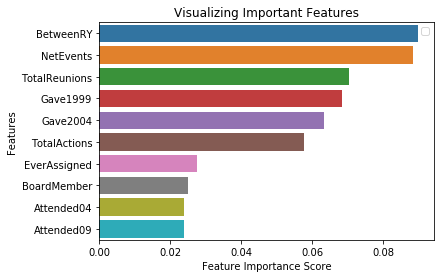

In [140]:
# Creating a bar plot
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Random Forest with top 10 important features

In [192]:
# Split dataset into features and labels
X2=df[['BetweenRY','NetEvents','Gave1999','TotalReunions','Gave2004','TotalActions','ActionNote','EverAssigned','Attended09','BoardMember']]  # Removed feature "sepal length"
Y2=df['Gave2009']                                       
# Split dataset into training set and test set
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.70, random_state=5) # 70% training and 30% test

In [193]:
rf2=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf2.fit(X2_train,Y2_train)

# prediction on test set
Y2_pred_rf =rf2.predict(X2_test)

Y2_proba_rf = rf2.predict_proba(X2_test)[:,1]
rf2auc = sklearn.metrics.roc_auc_score(Y2_test,Y2_proba_rf)
rf2auc

0.864069333090379

In [194]:
#MSE
from sklearn.metrics import mean_squared_error
sklearn.metrics.mean_squared_error(Y2_test, Y2_pred_rf, sample_weight=None, multioutput='uniform_average')

0.1276083467094703

In [195]:
rf2mse = mean_squared_error(Y2_test, rf2.predict(X2_test))
rf2mse

0.1276083467094703

## Lasso Regression

In [147]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [148]:
alphas = 10**np.linspace(10,-2,100)*0.5
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), Y_train)
    coefs.append(lasso.coef_)

In [149]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
Y_pred_lasso = lasso.predict(X_test)

In [206]:
lassocv.alpha_

7.165050613542156e-05

In [177]:
#MSE for lasso regression
lmse = mean_squared_error(Y_test, Y_pred_lasso)
lmse

0.08915316229825691

In [174]:
#AUC score for lasso
lassoauc = sklearn.metrics.roc_auc_score(Y_test, Y_pred_lasso)
lassoauc

0.8819282117383057

In [204]:
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
lc= lasso_coef[abs(lasso_coef)>0].sort_values(ascending=False)
lc

BetweenRY                                      0.231090
State_PR                                       0.137287
State_IN                                       0.130402
Gave2004                                       0.129219
ActionNote                                     0.099734
State_WI                                       0.089094
Gave1999                                       0.074057
Attended09                                     0.055743
ChildAlum                                      0.033004
State_MN                                       0.014062
TotalReunions                                  0.013401
SpouseAlum                                     0.012660
BoardMember                                    0.012155
EverAssigned                                   0.012013
UGAlumAwards                                   0.009271
WealthEngineRating_4: $250,000-$499,999        0.008473
NetEvents                                      0.008403
Attended04                                     0

In [201]:
lassoreg = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassoreg.fit(X_train, Y_train)

lasso.set_params(alpha=lassoreg.alpha_)
lasso.fit(X_train, Y_train)
Y_pred_lasso2 = lasso.predict(X_test)

In [202]:
#MSE for lasso regression
lmse2 = mean_squared_error(Y_test, Y_pred_lasso2)
lmse2

0.08915316229825691

In [203]:
#AUC score for lasso
lassoauc2 = sklearn.metrics.roc_auc_score(Y_test, Y_pred_lasso)
lassoauc2

0.8819282117383057

In [154]:
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
lc= lasso_coef[abs(lasso_coef)>0].sort_values(ascending=False)

In [233]:
pd.DataFrame(lc).reset_index(level=0)

,index,0
0,BetweenRY,0.231090
1,State_PR,0.137287
2,State_IN,0.130402
3,Gave2004,0.129219
4,ActionNote,0.099734
5,State_WI,0.089094
6,Gave1999,0.074057
7,Attended09,0.055743
8,ChildAlum,0.033004
9,State_MN,0.014062


### OLS

In [92]:
df1 = df.copy()
df1['const'] = 1

In [156]:
import statsmodels.api as sm

reg1 = sm.OLS(endog=Y_train, exog=X_train, missing='drop')
type(reg1)

statsmodels.regression.linear_model.OLS

In [157]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [158]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Gave2009   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     33.73
Date:                Sat, 09 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:51:59   Log-Likelihood:                -758.61
No. Observations:                4984   AIC:                             1717.
Df Residuals:                    4884   BIC:                             2369.
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
SpouseAlum                                      0.0184      0.013      1.453      0.146      -0.006       0.043
Gave2004                                        0.1286      0.014      9.423      0.000       0.102       0.155
Gave1999                                        0.0756      0.012      6.329      0.000       0.052       0.099
BetweenRY                                       0.2384      0.012     20.366      0.000       0.215       0.261
ActionNote                                      0.1009      0.018      5.703      0.000       0.066       0.136
SportsAlum                                     -0.0363      0.014     -2.635      0.008      -0.063      -0.009
UGAlumAwards                                    0.0376      0.022      1.712      0.087      -0.005       0.081
OtherUGAct                                     -0.0041      0.010     -0.391      0.696      -0.024       0.016
EverAssigned                                    0.0294      0.022      1.336      0.182      -0.014       0.073
BoardMember                                     0.0167      0.020      0.831      0.406      -0.023       0.056
ChildAlum                                       0.0449      0.019      2.401      0.016       0.008       0.081
ParentAlum                                     -0.0007      0.017     -0.043      0.965      -0.033       0.032
SiblingAlum                                     0.0162      0.013      1.274      0.203      -0.009       0.041
GradDegree                                     -0.0181      0.014     -1.257      0.209      -0.046       0.010
Attended09                                      0.0559      0.017      3.349      0.001       0.023       0.089
Attended04                                      0.0158      0.016      1.000      0.317      -0.015       0.047
Attended99                                      0.0018      0.015      0.119      0.905      -0.027       0.031
TotalReunions                                   0.0140      0.003      4.644      0.000       0.008       0.020
NetEvents                                       0.0082      0.002      4.963      0.000       0.005       0.011
OnePlusEvents                                   0.0006      0.010      0.055      0.956      -0.020       0.021
TotalActions                                    0.0054      0.002      2.379      0.017       0.001       0.010
WealthEngineRating_                             0.0061      0.017      0.360      0.719      -0.027       0.039
WealthEngineRating_1: $5,000,000+              -0.0490      0.209     -0.234      0.815      -0.460       0.362
WealthEngineRating_2: $1,000,000-$4,999,999    -0.0825      0.033     -2.499      0.012      -0.147      -0.018
WealthEngineRating_3: $500,000-$999,999        -0.0136     

In [159]:
results.pvalues

SpouseAlum                                     1.461784e-01
Gave2004                                       6.582553e-21
Gave1999                                       2.687109e-10
BetweenRY                                      1.454605e-88
ActionNote                                     1.243057e-08
SportsAlum                                     8.442429e-03
UGAlumAwards                                   8.697117e-02
OtherUGAct                                     6.960270e-01
EverAssigned                                   1.815929e-01
BoardMember                                    4.060754e-01
ChildAlum                                      1.640238e-02
ParentAlum                                     9.654366e-01
SiblingAlum                                    2.025997e-01
GradDegree                                     2.087484e-01
Attended09                                     8.161050e-04
Attended04                                     3.172074e-01
Attended99                              

In [160]:
results.params.sort_values(ascending=False)[0:50]

State_PR                                       0.374837
State_IN                                       0.262137
BetweenRY                                      0.238415
State_WI                                       0.168183
State_NH                                       0.149430
Gave2004                                       0.128553
State_PA                                       0.107094
ActionNote                                     0.100919
State_OK                                       0.094377
State_MN                                       0.093648
State_MT                                       0.079602
State_CT                                       0.076390
Gave1999                                       0.075623
Attended09                                     0.055858
WealthEngineRating_C: $1-$2,499                0.053227
State_NS                                       0.048063
State_NY                                       0.046828
State_ME                                       0

In [162]:
resultsdf = pd.DataFrame({'coefs':results.params, 'pval':results.pvalues})

In [166]:
resultsdf[resultsdf.pval<=0.05].sort_values(by='coefs',ascending=False).head(10)

,coefs,pval
State_IN,0.262137,2.371547e-02
BetweenRY,0.238415,1.454605e-88
State_WI,0.168183,9.576504e-03
Gave2004,0.128553,6.582553e-21
ActionNote,0.100919,1.243057e-08
Gave1999,0.075623,2.687109e-10
Attended09,0.055858,8.161050e-04
ChildAlum,0.044854,1.640238e-02
TotalReunions,0.013998,3.506131e-06
NetEvents,0.008169,7.175025e-07


In [168]:
Y_pred_ols = results.predict(X_test)

In [173]:
#AUC score for ols
olsauc = sklearn.metrics.roc_auc_score(Y_test, Y_pred_ols)
olsauc

0.8772398351721742

In [171]:
olsmse = mean_squared_error(Y_test, Y_pred_ols)
olsmse

0.09029581231684032

## Identifying Top 40

### Top 40 Lasso

In [207]:
lassoreg = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassoreg.fit(X, Y)

lasso.set_params(alpha=lassoreg.alpha_)
Y_pred_lasso2 = lassoreg.predict(X)

In [214]:
Y_pred_lasso2

array([-0.00490571,  0.00087652,  0.00087652, ...,  0.00949778,
        0.05649414,  0.01170423])

In [215]:
Y_pred_lasso2_indexed = pd.Series(
    data=Y_pred_lasso2, index=X.index.values, name='response', dtype=np.float32)

In [216]:
top40_lasso = Y_pred_lasso2_indexed.sort_values(ascending=False).head(int((len(X)*.4))).index.tolist()

In [217]:
t40_lasso = X.loc[top40_lasso,]

In [218]:
pd.DataFrame(t40_lasso.mean().sort_values(ascending=False).reset_index(level=0)[0:50].head(30))

,index,0
0,NetEvents,3.421699
1,TotalReunions,2.497191
2,TotalActions,1.163272
3,BetweenRY,0.736306
4,State_CA,0.733146
5,OnePlusEvents,0.662219
6,Gave1999,0.497893
7,Gave2004,0.459270
8,Attended09,0.333216
9,"WealthEngineRating_5: $100,000-$249,999",0.291784


In [219]:
bot60_lasso = Y_pred_lasso2_indexed.sort_values(ascending=True).head(int((len(X)*.6))).index.tolist()

In [220]:
bot60_lasso = X.loc[bot60_lasso,]

In [221]:
bot60_lasso.mean().sort_values(ascending=False)

State_CA                                       0.610955
NetEvents                                      0.459504
TotalReunions                                  0.299860
WealthEngineRating_                            0.286283
OnePlusEvents                                  0.240169
WealthEngineRating_5: $100,000-$249,999        0.211610
RYCohort_1999                                  0.200375
OtherUGAct                                     0.174157
RYCohort_1994                                  0.170646
WealthEngineRating_6: $50,000-$99,999          0.142556
RYCohort_1989                                  0.136704
RYCohort_1979                                  0.119148
RYCohort_1984                                  0.117509
WealthEngineRating_4: $250,000-$499,999        0.109082
SiblingAlum                                    0.104167
State_                                         0.103933
RYCohort_1974                                  0.099017
WealthEngineRating_7: $25,000-$49,999          0

In [222]:
(t40_lasso.mean().sort_values(ascending=False) - bot60_lasso.mean().sort_values(ascending=False)).sort_values(ascending=False)

NetEvents                                      2.962196
TotalReunions                                  2.197331
TotalActions                                   1.158825
BetweenRY                                      0.736306
Gave2004                                       0.459270
Gave1999                                       0.441713
OnePlusEvents                                  0.422051
Attended09                                     0.287336
ActionNote                                     0.286517
Attended99                                     0.205407
Attended04                                     0.186798
EverAssigned                                   0.155080
SpouseAlum                                     0.154026
BoardMember                                    0.144429
State_CA                                       0.122191
ChildAlum                                      0.110370
OtherUGAct                                     0.086025
WealthEngineRating_4: $250,000-$499,999        0

In [223]:
diff_lasso = pd.DataFrame((t40_lasso.mean().sort_values(ascending=False) - bot60_lasso.mean().sort_values(ascending=False))\
        .sort_values(ascending=False)).reset_index(level=0)[0:50].head(30)

In [225]:
diff_lasso

,index,0
0,NetEvents,2.962196
1,TotalReunions,2.197331
2,TotalActions,1.158825
3,BetweenRY,0.736306
4,Gave2004,0.459270
5,Gave1999,0.441713
6,OnePlusEvents,0.422051
7,Attended09,0.287336
8,ActionNote,0.286517
9,Attended99,0.205407


### Top 40 Random Forest

In [141]:
rf3 = RandomForestClassifier(random_state=2)
rf3.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

In [66]:
Y_proba_all = rf3.predict_proba(X)[:,1]

In [67]:
Y_proba_all_indexed = pd.Series(
    data=Y_proba_all, index=X.index.values, name='response', dtype=np.float32)

In [68]:
top40_all = Y_proba_all_indexed.sort_values(ascending=False).head(int((len(X)*.4))).index.tolist()

In [69]:
t40_all = X.loc[top40_all,]

In [226]:
pd.DataFrame(t40_all.mean().sort_values(ascending=False).reset_index(level=0)[0:50].head(30))

,index,0
0,NetEvents,3.109199
1,TotalReunions,2.224719
2,TotalActions,1.071278
3,State_CA,0.749298
4,OnePlusEvents,0.596208
5,BetweenRY,0.595154
6,Gave1999,0.438202
7,Gave2004,0.387289
8,"WealthEngineRating_5: $100,000-$249,999",0.308989
9,Attended09,0.301615


In [71]:
(t40_all.mean().sort_values(ascending=False) - df.mean().sort_values(ascending=False)).sort_values(ascending=False)

NetEvents                                      1.464817
TotalReunions                                  1.045927
TotalActions                                   0.603301
BetweenRY                                      0.300632
Gave1999                                       0.205337
Gave2004                                       0.203581
OnePlusEvents                                  0.187219
Attended09                                     0.140801
ActionNote                                     0.132233
State_CA                                       0.089466
Attended99                                     0.089185
Attended04                                     0.085042
EverAssigned                                   0.076896
BoardMember                                    0.076124
SpouseAlum                                     0.075211
WealthEngineRating_5: $100,000-$249,999        0.065309
ChildAlum                                      0.063062
WealthEngineRating_4: $250,000-$499,999        0

In [72]:
bot60_all = Y_proba_all_indexed.sort_values(ascending=True).head(int((len(X)*.6))).index.tolist()

In [73]:
bot60_all = X.loc[bot60_all,]

In [74]:
bot60_all.mean().sort_values(ascending=False)

NetEvents                                      0.667837
State_CA                                       0.600187
TotalReunions                                  0.481507
WealthEngineRating_                            0.290262
OnePlusEvents                                  0.284176
WealthEngineRating_5: $100,000-$249,999        0.200140
RYCohort_1999                                  0.190543
OtherUGAct                                     0.188904
RYCohort_1994                                  0.167837
WealthEngineRating_6: $50,000-$99,999          0.141386
RYCohort_1989                                  0.139045
RYCohort_1979                                  0.117978
RYCohort_1984                                  0.110721
SiblingAlum                                    0.108848
RYCohort_1974                                  0.108614
WealthEngineRating_4: $250,000-$499,999        0.104869
State_                                         0.101826
WealthEngineRating_7: $25,000-$49,999          0

In [75]:
(t40_all.mean().sort_values(ascending=False) - bot60_all.mean().sort_values(ascending=False)).sort_values(ascending=False)

NetEvents                                      2.441362
TotalReunions                                  1.743212
TotalActions                                   1.005501
BetweenRY                                      0.501053
Gave1999                                       0.342228
Gave2004                                       0.339302
OnePlusEvents                                  0.312032
Attended09                                     0.234668
ActionNote                                     0.220389
State_CA                                       0.149110
Attended99                                     0.148642
Attended04                                     0.141737
EverAssigned                                   0.128160
BoardMember                                    0.126873
SpouseAlum                                     0.125351
WealthEngineRating_5: $100,000-$249,999        0.108848
ChildAlum                                      0.105103
WealthEngineRating_4: $250,000-$499,999        0

In [126]:
diff = pd.DataFrame((t40_all.mean().sort_values(ascending=False) - bot60_all.mean().sort_values(ascending=False))\
        .sort_values(ascending=False)).reset_index(level=0)[0:50].head(30)

In [127]:
diff

,index,0
0,NetEvents,2.441362
1,TotalReunions,1.743212
2,TotalActions,1.005501
3,BetweenRY,0.501053
4,Gave1999,0.342228
5,Gave2004,0.339302
6,OnePlusEvents,0.312032
7,Attended09,0.234668
8,ActionNote,0.220389
9,State_CA,0.149110


## Tables & Charts for presentation

In [196]:
msedata = pd.DataFrame({'Method':['OLS','Lasso','Random Forest'],'Mean Squared Error':[olsmse, lmse, rf2mse]})

In [197]:
msedata

,Method,Mean Squared Error
0,OLS,0.090296
1,Lasso,0.089153
2,Random Forest,0.127608


In [198]:
import seaborn as sns
import math

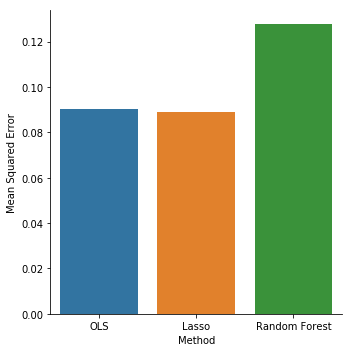

In [199]:
sns.catplot(data=msedata, x='Method', y='Mean Squared Error',kind='bar')

In [182]:
aucdata = pd.DataFrame({'Method':['OLS','Lasso','Random Forest'],'AUC Score':[olsauc, lassoauc, rf2auc]})

In [183]:
aucdata

,Method,AUC Score
0,OLS,0.877240
1,Lasso,0.881928
2,Random Forest,0.864363


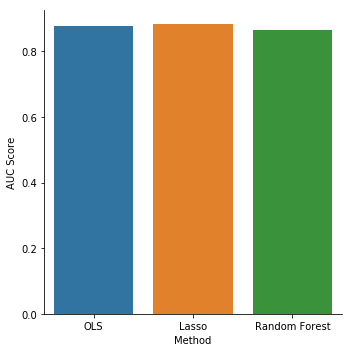

In [184]:
sns.catplot(data=aucdata, x='Method', y='AUC Score',kind='bar')

In [222]:
cohort = pd.DataFrame(df2.groupby('RYCohort')['Gave2009'].mean()).reset_index(level=0)
cohort

,RYCohort,Gave2009
0,1954,0.285714
1,1959,0.294118
2,1964,0.175487
3,1969,0.210750
4,1974,0.189225
5,1979,0.161117
6,1984,0.191176
7,1989,0.152311
8,1994,0.122201
9,1999,0.071930


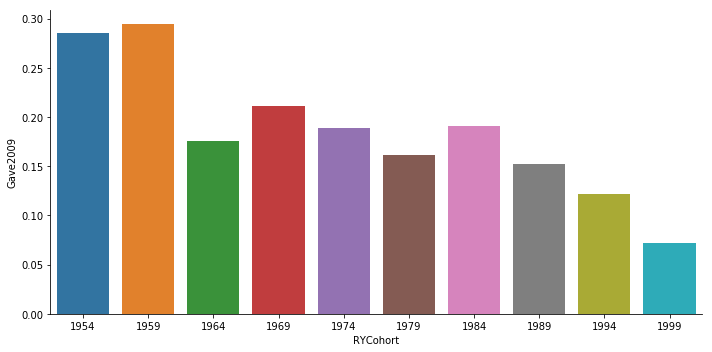

In [229]:
sns.catplot(data=cohort, x='RYCohort', y='Gave2009',kind='bar',aspect=2)

In [218]:
wealth = pd.DataFrame(df2.groupby('WealthEngineRating')['Gave2009'].mean()).reset_index(level=0)
wealth = wealth[1:]

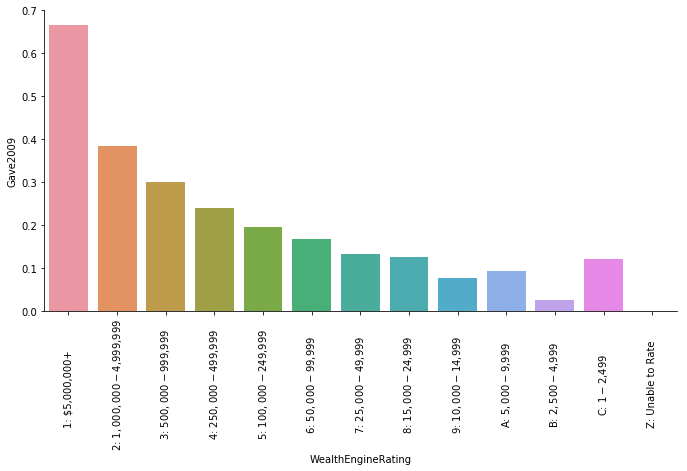

In [228]:
sns.catplot(data=wealth, x='WealthEngineRating', y='Gave2009',kind='bar',aspect=2).set_xticklabels(rotation=90)

In [185]:
totr = pd.DataFrame(df2.groupby('TotalReunions')['Gave2009'].mean()).reset_index(level=0)

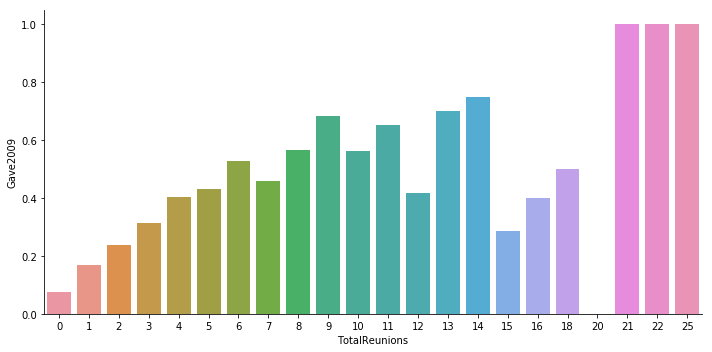

In [234]:
sns.catplot(data=totr, x='TotalReunions', y='Gave2009',kind='bar',aspect=2)